In [1]:
%matplotlib inline
from marketdata import *
from model import *
from analytics import *
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math
from datetime import datetime

import pylab
sns.set(font_scale=3)
pylab.rcParams['figure.figsize'] = (24, 18)

:0: FutureWarning: IPython widgets are experimental and may change in the future.


# Load data 


In [5]:
FundAUM=1e6
curr_px=get_most_liquid_price(mkts)
mkts=get_market_list()
df=pd.DataFrame()
for m in mkts:
    try:
        df[m]=get_timeseries(m)
    except:
        print m

# Idea is to add two different look back signals to the same model

* In theory every level should be vol scaled to ensure equal risk allocation (signal, market, and fund level as we don't have sectors here)
* Need to get the scaling factor correct.  Problably best to get the scaling factor correct in signal space then 

In [6]:
range(10,20,10)

[10]

In [10]:
pnl_combinations = pd.DataFrame()
for sh in range(10,60,10):
    for lg in range(20,60,10):
        if lg<=sh:
            continue
        pos=tsmom_daily(df[mkts],sh)
        pnl_short=calc_pnl_wc(pos,df[mkts])
        pos=tsmom_daily(df[mkts],lg)
        pnl_long=calc_pnl_wc(pos,df[mkts])
        combined_pnl=(pnl_short*.5+pnl_long*.5)
        scaling_factor=calc_scaling_factor(combined_pnl)
        s_short=tsmom_daily_signal(df,sh)
        s_long=tsmom_daily_signal(df,lg)
        s_combined = (s_short*.5+s_long*.5)
        lots=calc_position(s_combined,FundAUM,scaling_factor,curr_px)
        PNL = calc_pnl_position_wc(lots,df,curr_px)
        pnl_combinations[str(sh)+','+str(lg)]=(PNL.sum(axis=1)/FundAUM).dropna()       

model.py:7: FutureWarning: pd.ewm_std is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.ewm(ignore_na=False,min_periods=20,adjust=True,com=20).std(bias=False)
  vol=pd.ewmstd(data,vol_lookback,min_periods=vol_lookback)*math.sqrt(256)
model.py:8: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=10,center=False).mean()
  signal=pd.rolling_mean(data,signal_lookback)
model.py:8: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=20,center=False).mean()
  signal=pd.rolling_mean(data,signal_lookback)
model.py:15: FutureWarning: pd.ewm_std is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.ewm(ignore_na=False,min_periods=20,adjust=True,com=20).std(bias=False)
  vol=pd.ewmstd(data,vol_lookback,min_periods=vol_lookback)*math.sqrt(25

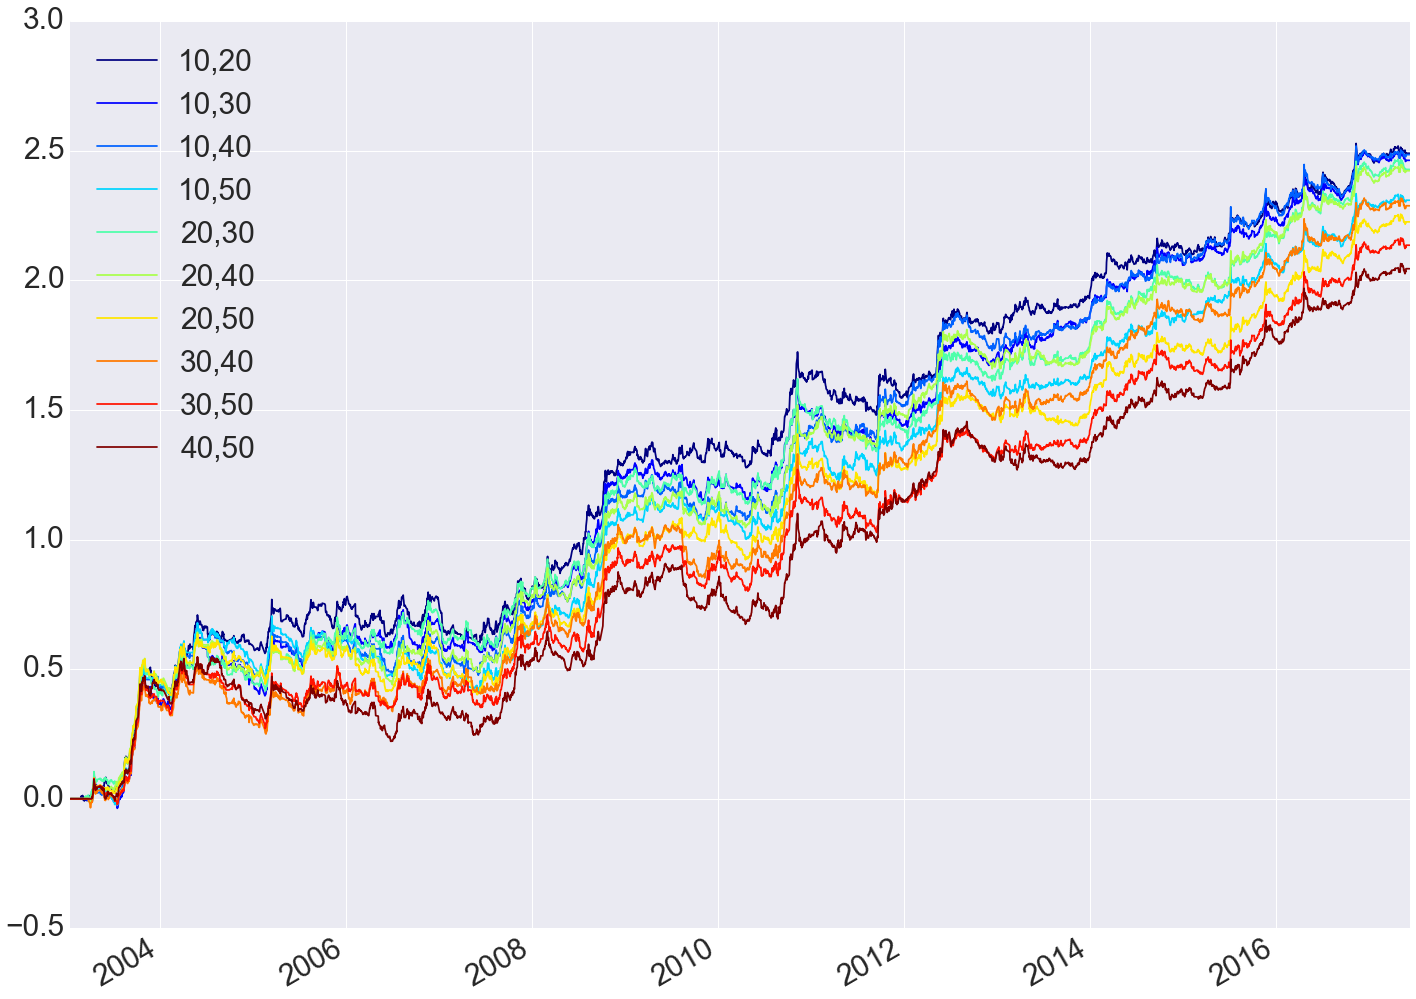

In [11]:
pnl_combinations.cumsum().plot(colormap='jet')

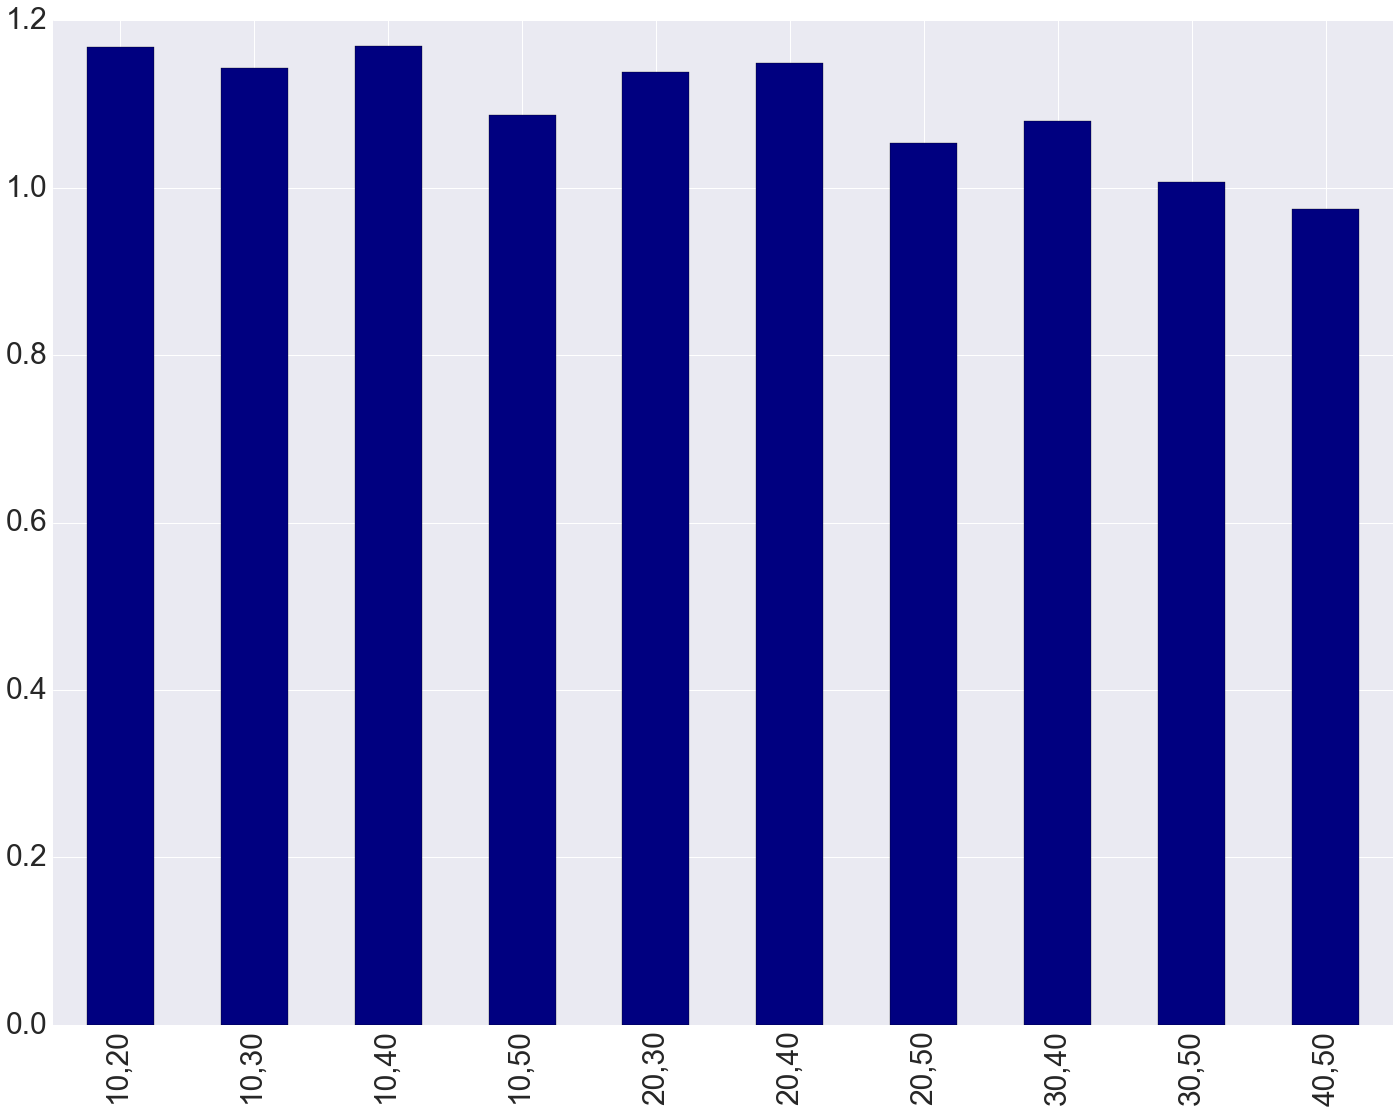

In [12]:
calc_Sharpe(pnl_combinations).plot(kind='bar',colormap='jet')

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  if __name__ == '__main__':
/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: FutureWarning: pd.rolling_max is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(min_periods=1,window=1000000,center=False).max()
  from IPython.kernel.zmq import kernelapp as app


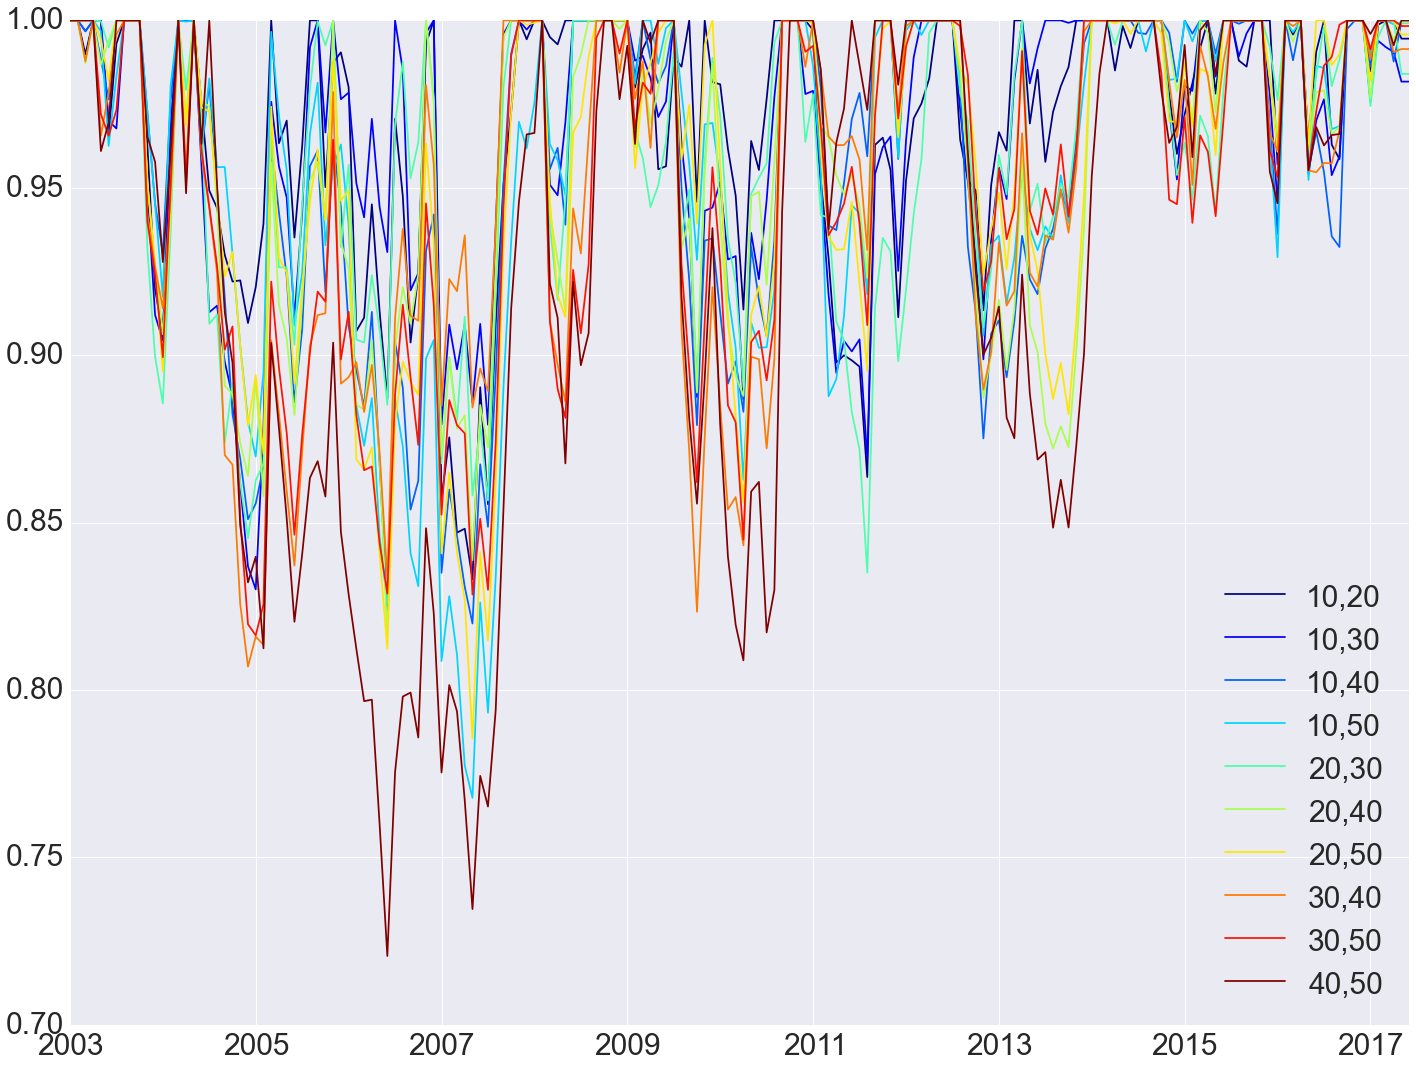

In [13]:
temp=(pnl_combinations.resample(rule='m',how='sum')+1).cumprod()
(temp/pd.rolling_max(temp,1000000,min_periods=1)).plot(colormap='jet')

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: FutureWarning: pd.rolling_max is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(min_periods=1,window=1000000,center=False).max()
  if __name__ == '__main__':


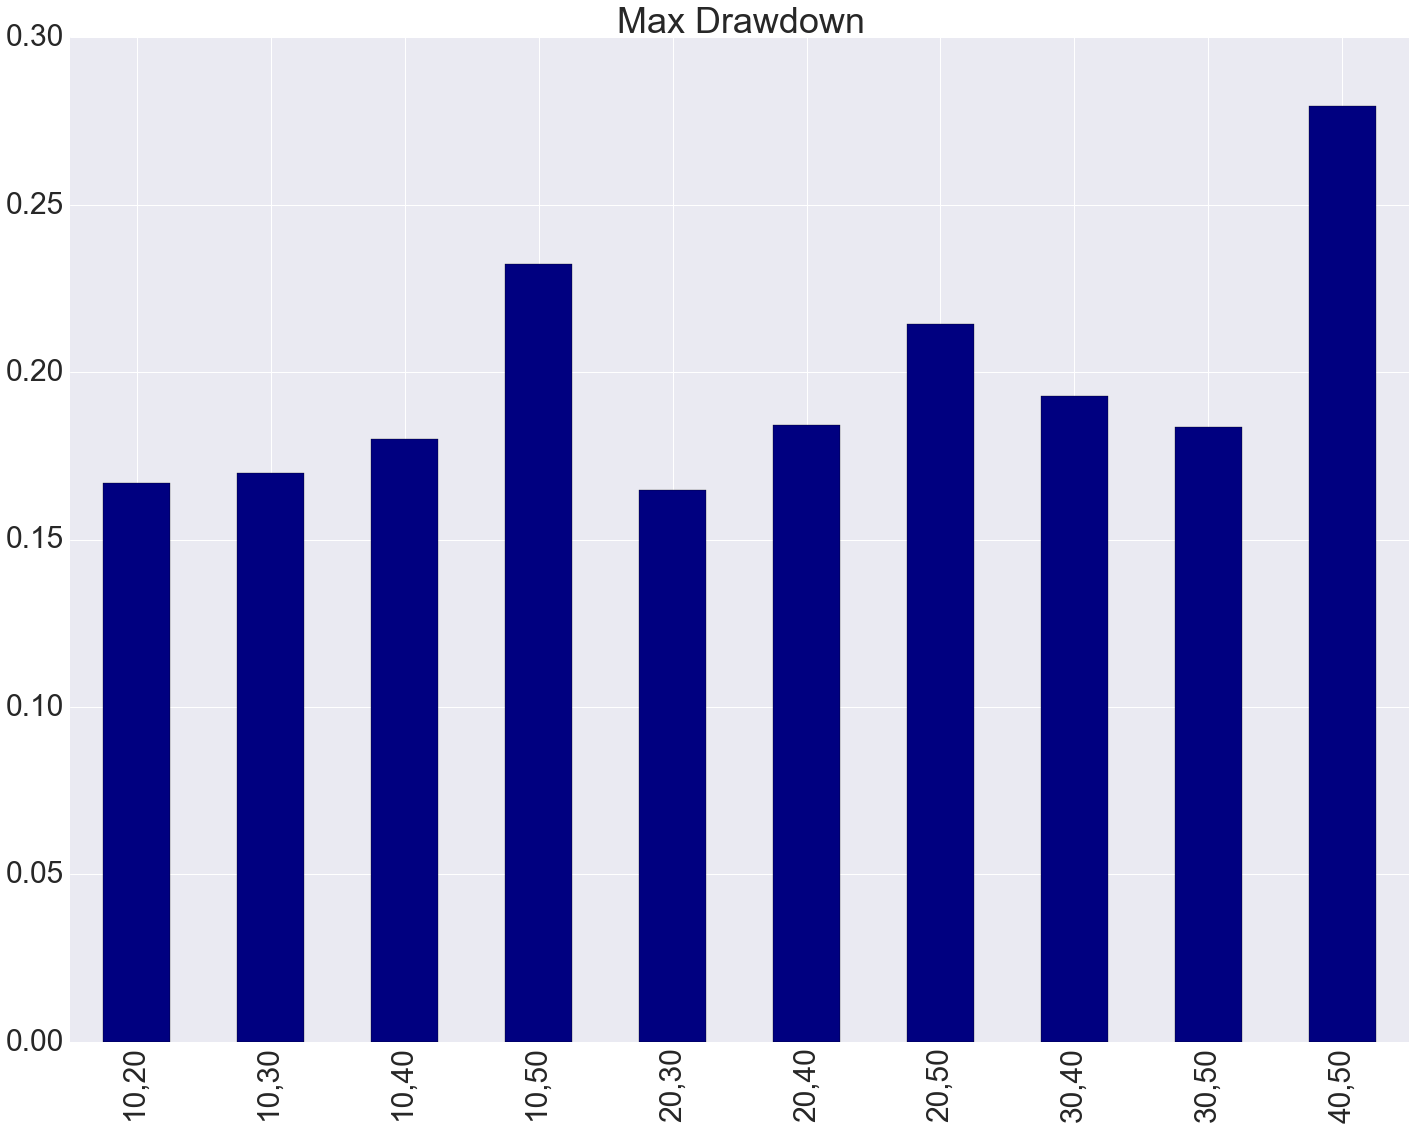

In [14]:
temp2=(1-(temp/pd.rolling_max(temp,1000000,min_periods=1)).min())
temp2.plot(kind='bar',colormap='jet',title='Max Drawdown')

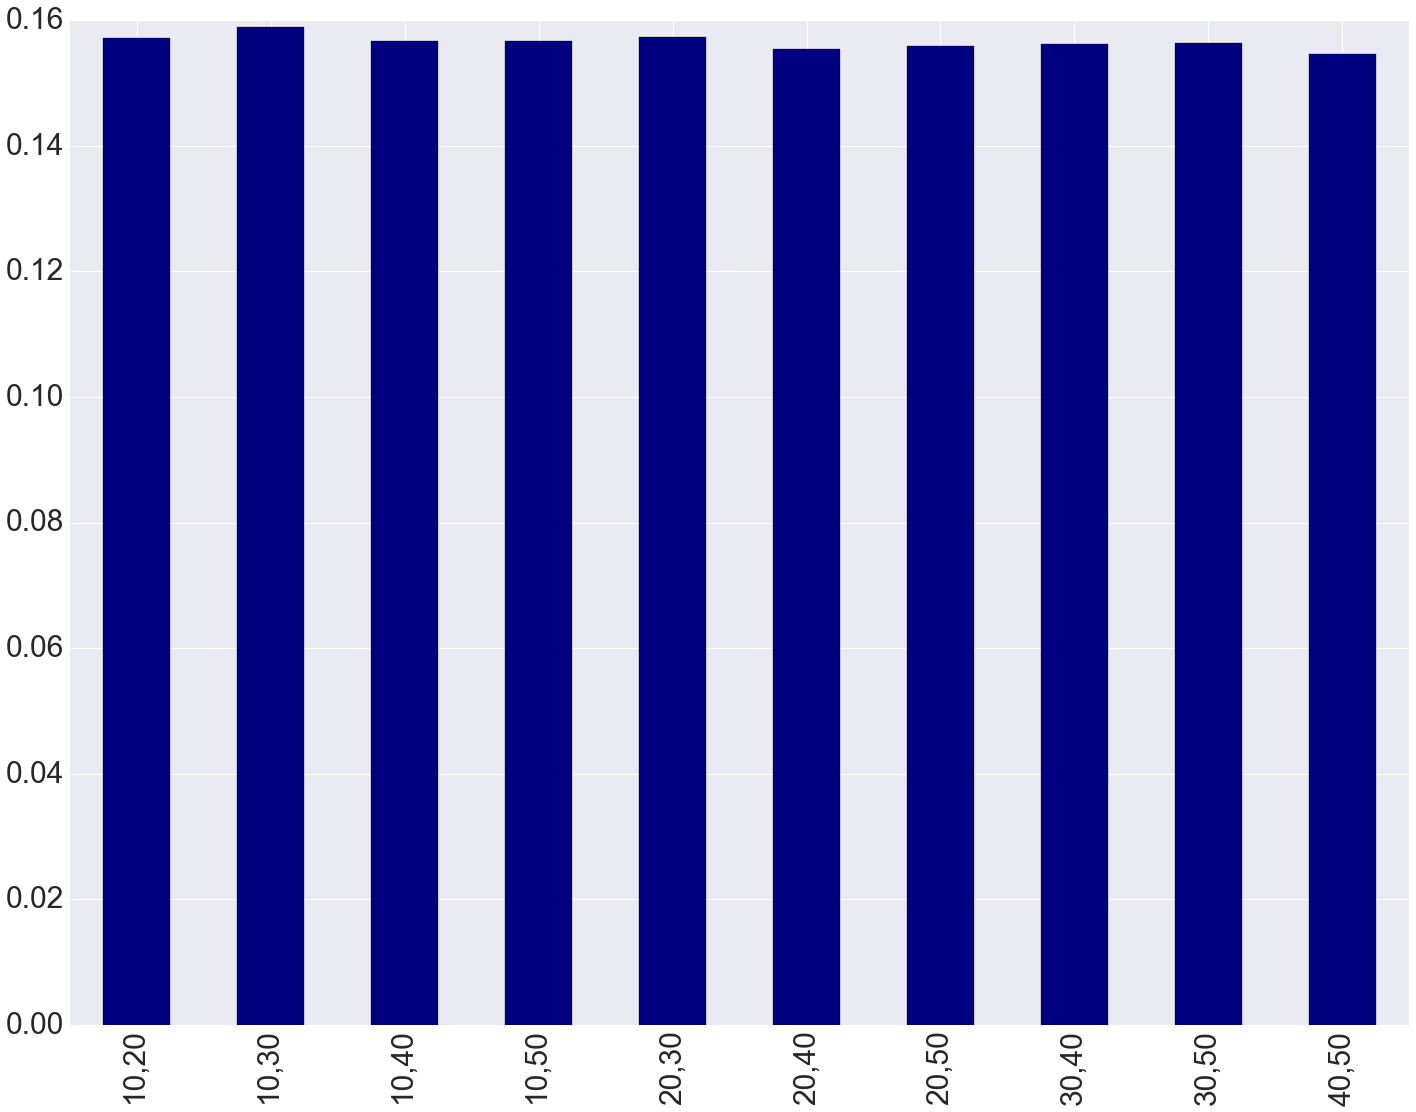

In [17]:
(pnl_combinations.std()*16).plot(kind='bar',colormap='jet')

/Users/mrefermat/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


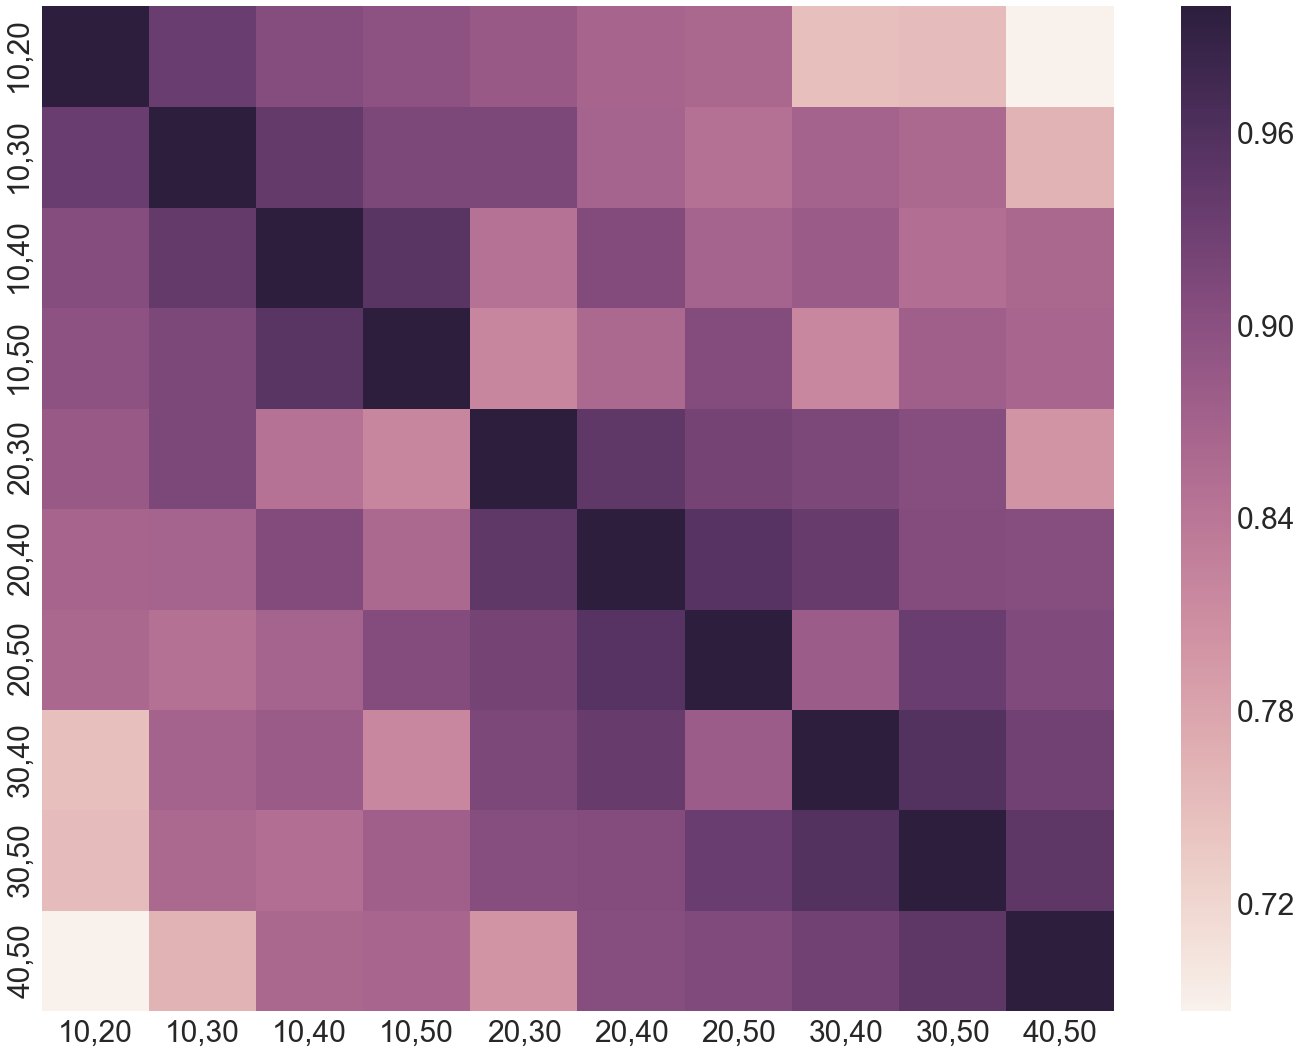

In [19]:
sns.heatmap(pnl_combinations.corr())